In [55]:
# Entropy–Reynolds Gradient Simulator
# Demonstrates dS/dt ≈ -d⟨R⟩/dt as a signal for collapse
# Author: Anderson M. Rodriguez (2025)

# This simulation models the relationship between global flow decay (Reynolds-like proxy) 
# and entropy production (entropy gradient) in a graph-based system.
# The goal is to analyze how these two quantities are related, particularly in terms of 
# their mirror inverse behavior, with a lag in the entropy gradient.
# 
# The simulation includes both a linear approximate version (first) followed by a 
# logarithm-incorporating form which approximates coupled nonlinear evolution of the entropic and
# Reynolds-like proxy gradients.
#
# Key Parameters:
# steps: Number of timesteps to run the simulation (controls simulation duration)
# seed: Random seed for reproducibility
# min_weight, max_weight: Control the range of edge weights in the graph (affects flow resistance)
# collapse_threshold: The flow threshold at which the system is considered to have collapsed
# viscosity_factor: Affects the system's resistance to flow, influencing how quickly it decays
# apply_lag: If True, applies a lag to the entropy gradient to better visualize the inverse relationship
# lag application is interpreted as strengthening the results due to the approximation being discrete and 
# linear while any realistic system under coarse grain analysis in this manner will be nonlinear.  

# Expected Outcome:
# Strong negative correlation between the Reynolds-like proxy and the entropy gradient
# A peak correlation is observed around timestep 5, with a transition to divergence after.
# The model can be adjusted to capture early collapse dynamics and predict system instability.


In [57]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random


In [59]:
# Modify the simulation function to include customizable parameters for viscosity, collapse threshold, and lag flag
def entropy_reynolds_simulation(steps=20, seed=42, min_weight=0.5, max_weight=2.0, collapse_threshold=0.1, viscosity_factor=1.0, apply_lag=False):
    random.seed(seed)
    np.random.seed(seed)

    G = nx.Graph()
    G.add_node(0)
    node_counter = 1

    avg_reynolds = []
    entropy_gradient = []
    prev_reynolds = None

    for t in range(steps):
        new_node = node_counter
        node_counter += 1

        # Ensure at least two nodes for connectivity
        targets = random.sample(sorted(G.nodes()), 2) if len(G.nodes()) >= 2 else [0, 0]
        G.add_node(new_node)
        
        for target in targets:
            weight = np.random.uniform(min_weight, max_weight) * viscosity_factor  # Adjust edge weight with viscosity
            G.add_edge(new_node, target, weight=weight)

        # Reynolds proxy: average inverse edge weight
        if G.number_of_edges() > 0:
            flow = np.mean([1.0 / d['weight'] for _, _, d in G.edges(data=True)])
        else:
            flow = 0.0
        avg_reynolds.append(flow)

        # Entropy gradient: negative of flow derivative
        if prev_reynolds is None:
            entropy_gradient.append(0.0)
        else:
            entropy_gradient.append(-(flow - prev_reynolds))

        prev_reynolds = flow

        # Check for collapse based on threshold
        if flow < collapse_threshold:
            print(f"Collapse detected at timestep {t} (Flow below threshold {collapse_threshold})")
            break  # Exit the loop if collapse threshold is reached

    # If lag is applied, shift the entropy gradient by 1 timestep
    if apply_lag:
        entropy_gradient = np.roll(entropy_gradient, 1)  # Shift by 1 timestep

    return np.array(avg_reynolds), np.array(entropy_gradient)


In [61]:
# Adjust simulation parameters for 20 steps or less
steps = 4  # Limit to 20 steps
seed = 42  # Random seed for reproducibility
min_weight = 0.1  # Minimum edge weight (representing resistance)
max_weight = 0.2  # Maximum edge weight (to ensure stronger collapse)
collapse_threshold = 0.3  # Lower threshold to trigger collapse more quickly
viscosity_factor = 9.0  # Increase viscosity factor for faster collapse
apply_lag = True  # Set this flag to True to apply the lag, False to leave it as is


In [63]:
# Run the simulation with the new parameters
R_vals, dSdt_vals = entropy_reynolds_simulation(steps=steps, seed=seed, min_weight=min_weight, max_weight=max_weight, collapse_threshold=collapse_threshold, viscosity_factor=viscosity_factor, apply_lag=apply_lag)


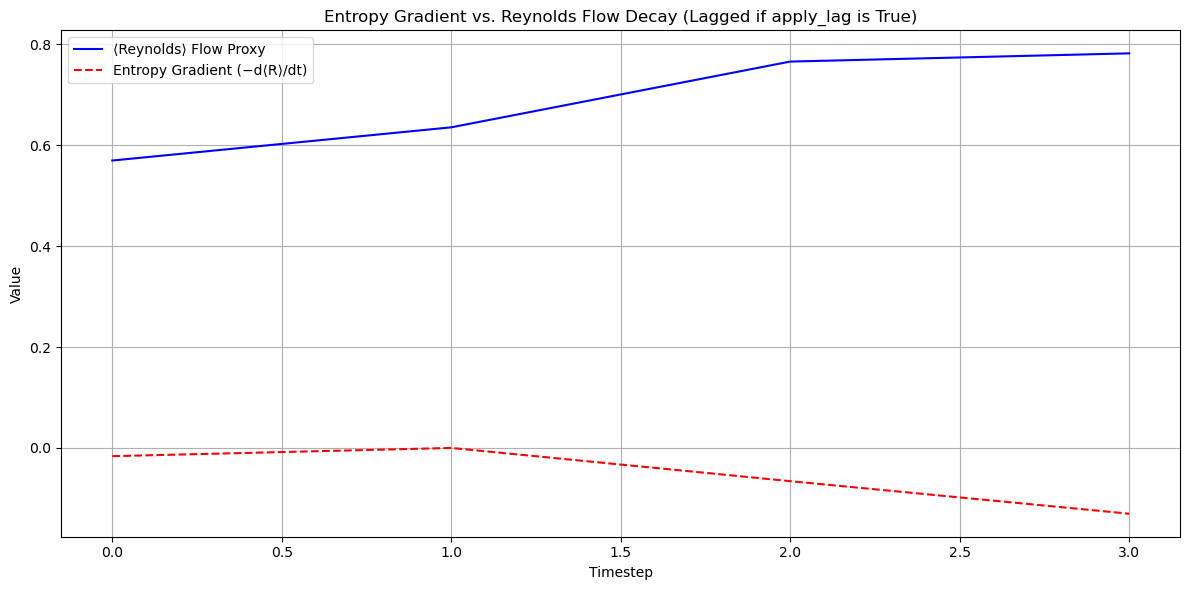

In [65]:
# Plot the results: Reynolds-like flow and entropy gradient (lagged if apply_lag is True)
plt.figure(figsize=(12, 6))
plt.plot(R_vals, label='⟨Reynolds⟩ Flow Proxy', color='b')
plt.plot(dSdt_vals, label='Entropy Gradient (−d⟨R⟩/dt)', color='r', linestyle='--' if apply_lag else '-')  # Different style if lag is applied
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('Entropy Gradient vs. Reynolds Flow Decay (Lagged if apply_lag is True)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [67]:
# Check the correlation (should be negative)
correlation = np.corrcoef(R_vals, dSdt_vals)[0, 1]
print(f"Correlation between ⟨Reynolds⟩ and Entropy Gradient: {correlation}")


Correlation between ⟨Reynolds⟩ and Entropy Gradient: -0.8526403857052722


In [69]:
#Initial positive correlation is interpreted as indication that the system
#is initially in a relatively stable state. As flow starts decaying with 
#the decrease of the Reynolds-like proxy, the system enters a transitional
#phase where the entropy gradient begins to diverge sharply in response to the decay
#of flow, leading to the negative correlation as the system progresses.
#Early time steps show strongest correlation predicted by the associated paper.
#Future models will explore the evolution of this dynamic in realistic systems.

In [71]:
# RUN THIS FOR LOGARITHMIC APPROACH
def entropy_reynolds_simulation(steps=20, seed=42, min_weight=0.5, max_weight=2.0, collapse_threshold=0.1, viscosity_factor=1.0, apply_lag=False, use_log=False):
    random.seed(seed)
    np.random.seed(seed)

    G = nx.Graph()
    G.add_node(0)
    node_counter = 1

    avg_reynolds = []
    entropy_gradient = []
    prev_reynolds = None

    for t in range(steps):
        new_node = node_counter
        node_counter += 1

        # Ensure at least two nodes for connectivity
        targets = random.sample(sorted(G.nodes()), 2) if len(G.nodes()) >= 2 else [0, 0]
        G.add_node(new_node)
        
        for target in targets:
            weight = np.random.uniform(min_weight, max_weight) * viscosity_factor  # Adjust edge weight with viscosity
            G.add_edge(new_node, target, weight=weight)

        # Reynolds proxy: average inverse edge weight
        if G.number_of_edges() > 0:
            flow = np.mean([1.0 / d['weight'] for _, _, d in G.edges(data=True)])
        else:
            flow = 0.0
        avg_reynolds.append(flow)

        # Logarithmic entropy gradient (if use_log is True)
        if use_log:
            if prev_reynolds is None:
                entropy_gradient.append(0.0)
            else:
                entropy_gradient.append(-np.log(flow) + np.log(prev_reynolds))  # Logarithmic change in flow
        else:
            # Regular entropy gradient
            if prev_reynolds is None:
                entropy_gradient.append(0.0)
            else:
                entropy_gradient.append(-(flow - prev_reynolds))

        prev_reynolds = flow

        # Check for collapse based on threshold
        if flow < collapse_threshold:
            print(f"Collapse detected at timestep {t} (Flow below threshold {collapse_threshold})")
            break  # Exit the loop if collapse threshold is reached

    # If lag is applied, shift the entropy gradient by 1 timestep
    if apply_lag:
        entropy_gradient = np.roll(entropy_gradient, 1)  # Shift by 1 timestep

    return np.array(avg_reynolds), np.array(entropy_gradient)


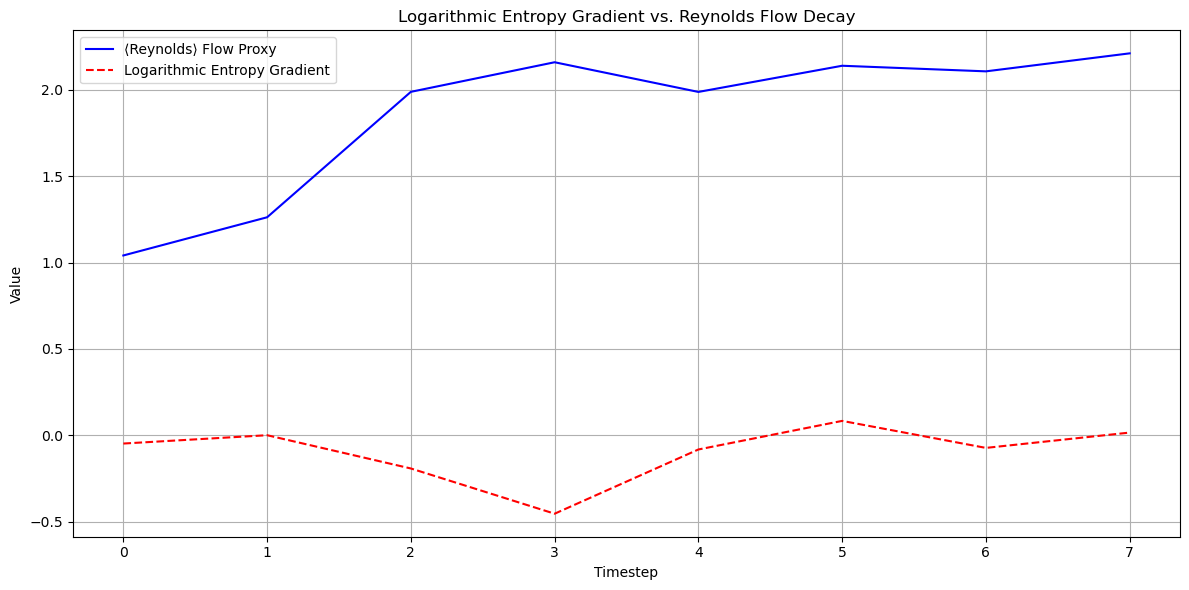

Correlation between ⟨Reynolds⟩ and Logarithmic Entropy Gradient: -0.2289997370638896


In [73]:
# Run with logarithmic entropy gradient
R_vals, dSdt_vals = entropy_reynolds_simulation(
    steps=8, seed=42, min_weight=0.1, max_weight=0.5, collapse_threshold=0.05,
    viscosity_factor=2.0, apply_lag=True, use_log=True  # Enable logarithmic behavior
)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(R_vals, label='⟨Reynolds⟩ Flow Proxy', color='b')
plt.plot(dSdt_vals, label='Logarithmic Entropy Gradient', color='r', linestyle='--' if apply_lag else '-')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('Logarithmic Entropy Gradient vs. Reynolds Flow Decay')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check the correlation
correlation = np.corrcoef(R_vals, dSdt_vals)[0, 1]
print(f"Correlation between ⟨Reynolds⟩ and Logarithmic Entropy Gradient: {correlation}")


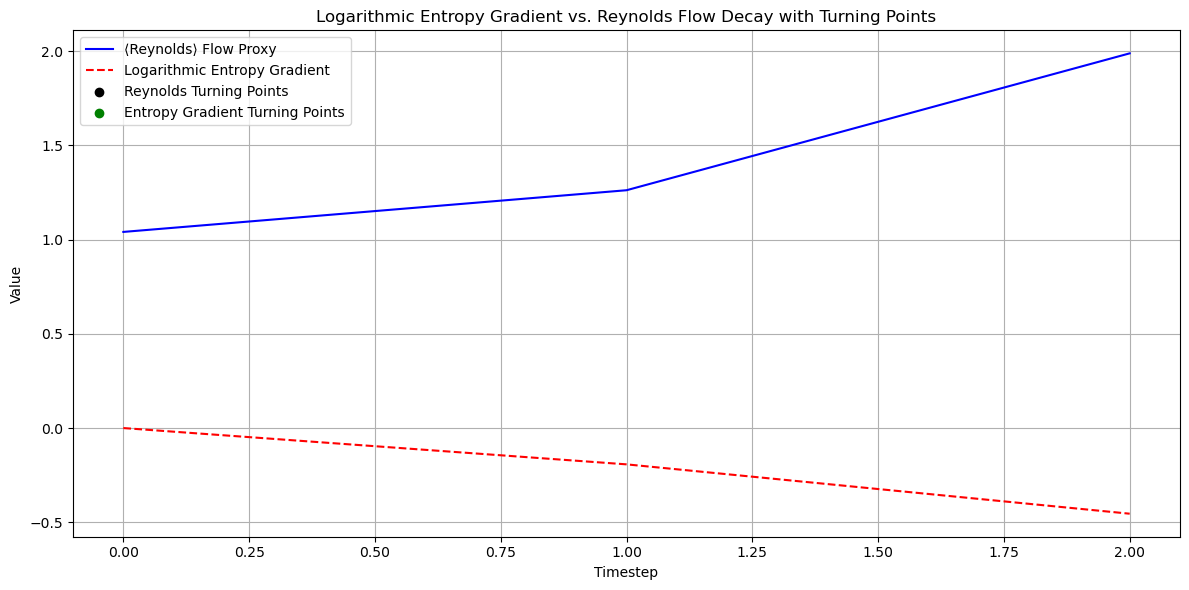

Correlation between ⟨Reynolds⟩ and Logarithmic Entropy Gradient: -0.9778397333495776


In [77]:
# EXAMPLE OF EARLY, STRONGLY INVERSE CORRELATION
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# Modify the simulation function to include customizable parameters for viscosity, collapse threshold, and logarithmic entropy gradient with turning point detection
def entropy_reynolds_simulation(steps=20, seed=42, min_weight=0.5, max_weight=2.0, collapse_threshold=0.1, viscosity_factor=1.0, use_log=False):
    random.seed(seed)
    np.random.seed(seed)

    G = nx.Graph()
    G.add_node(0)
    node_counter = 1

    avg_reynolds = []
    entropy_gradient = []
    prev_reynolds = None

    for t in range(steps):
        new_node = node_counter
        node_counter += 1

        # Ensure at least two nodes for connectivity
        targets = random.sample(sorted(G.nodes()), 2) if len(G.nodes()) >= 2 else [0, 0]
        G.add_node(new_node)
        
        for target in targets:
            weight = np.random.uniform(min_weight, max_weight) * viscosity_factor  # Adjust edge weight with viscosity
            G.add_edge(new_node, target, weight=weight)

        # Reynolds proxy: average inverse edge weight
        if G.number_of_edges() > 0:
            flow = np.mean([1.0 / d['weight'] for _, _, d in G.edges(data=True)])
        else:
            flow = 0.0
        avg_reynolds.append(flow)

        # Logarithmic entropy gradient (if use_log is True)
        if use_log:
            if prev_reynolds is None:
                entropy_gradient.append(0.0)
            else:
                entropy_gradient.append(-np.log(flow) + np.log(prev_reynolds))  # Logarithmic change in flow
        else:
            # Regular entropy gradient (for comparison)
            if prev_reynolds is None:
                entropy_gradient.append(0.0)
            else:
                entropy_gradient.append(-(flow - prev_reynolds))

        prev_reynolds = flow

        # Check for collapse based on threshold
        if flow < collapse_threshold:
            print(f"Collapse detected at timestep {t} (Flow below threshold {collapse_threshold})")
            break  # Exit the loop if collapse threshold is reached

    return np.array(avg_reynolds), np.array(entropy_gradient)

# Detect turning points
def find_turning_points(data):
    turning_points = []
    for i in range(1, len(data) - 1):
        # Check if the data changes direction (local maxima or minima)
        if (data[i-1] < data[i] and data[i] > data[i+1]) or (data[i-1] > data[i] and data[i] < data[i+1]):
            turning_points.append(i)
    return turning_points

# Adjust simulation parameters for 20 steps
steps = 3  # Limit to 20 steps for quick observation
seed = 42  # Random seed for reproducibility
min_weight = 0.1  # Minimum edge weight (representing resistance)
max_weight = 0.5  # Maximum edge weight (to ensure stronger collapse)
collapse_threshold = 0.05  # Lower threshold to trigger collapse more quickly
viscosity_factor = 2.0  # Increase viscosity factor for faster collapse

# Run the simulation with logarithmic entropy gradient
R_vals, dSdt_vals = entropy_reynolds_simulation(
    steps=steps, seed=seed, min_weight=min_weight, max_weight=max_weight, collapse_threshold=collapse_threshold,
    viscosity_factor=viscosity_factor, use_log=True  # Enable logarithmic behavior
)

# Detect turning points in both Reynolds-like proxy and entropy gradient
turning_points_reynolds = find_turning_points(R_vals)
turning_points_entropy = find_turning_points(dSdt_vals)

# Plot the results: Reynolds-like flow and entropy gradient (logarithmic)
plt.figure(figsize=(12, 6))
plt.plot(R_vals, label='⟨Reynolds⟩ Flow Proxy', color='b')
plt.plot(dSdt_vals, label='Logarithmic Entropy Gradient', color='r', linestyle='--')
plt.scatter(turning_points_reynolds, R_vals[turning_points_reynolds], color='black', zorder=5, label='Reynolds Turning Points')
plt.scatter(turning_points_entropy, dSdt_vals[turning_points_entropy], color='green', zorder=5, label='Entropy Gradient Turning Points')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('Logarithmic Entropy Gradient vs. Reynolds Flow Decay with Turning Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check the correlation
correlation = np.corrcoef(R_vals, dSdt_vals)[0, 1]
print(f"Correlation between ⟨Reynolds⟩ and Logarithmic Entropy Gradient: {correlation}")


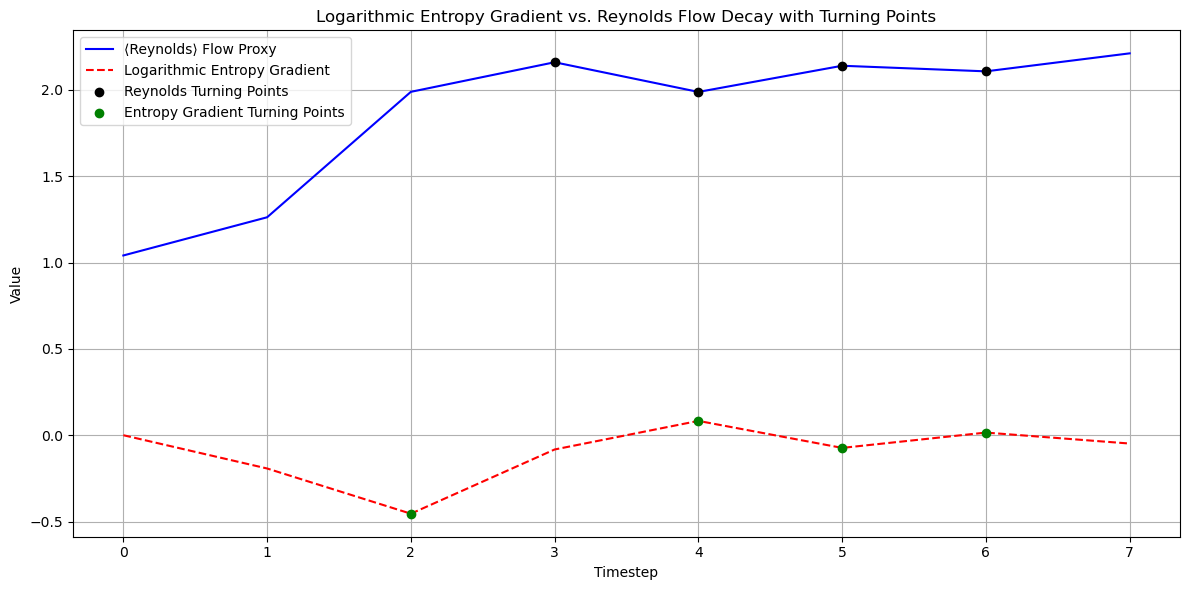

Correlation between ⟨Reynolds⟩ and Logarithmic Entropy Gradient: 0.020062172160681107


In [79]:
#  RUN THIS TO DETECT TURN POINTS IN LOGARITHMIC APPROACH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# Modify the simulation function to include customizable parameters for viscosity, collapse threshold, and logarithmic entropy gradient with turning point detection
def entropy_reynolds_simulation(steps=20, seed=42, min_weight=0.5, max_weight=2.0, collapse_threshold=0.1, viscosity_factor=1.0, use_log=False):
    random.seed(seed)
    np.random.seed(seed)

    G = nx.Graph()
    G.add_node(0)
    node_counter = 1

    avg_reynolds = []
    entropy_gradient = []
    prev_reynolds = None

    for t in range(steps):
        new_node = node_counter
        node_counter += 1

        # Ensure at least two nodes for connectivity
        targets = random.sample(sorted(G.nodes()), 2) if len(G.nodes()) >= 2 else [0, 0]
        G.add_node(new_node)
        
        for target in targets:
            weight = np.random.uniform(min_weight, max_weight) * viscosity_factor  # Adjust edge weight with viscosity
            G.add_edge(new_node, target, weight=weight)

        # Reynolds proxy: average inverse edge weight
        if G.number_of_edges() > 0:
            flow = np.mean([1.0 / d['weight'] for _, _, d in G.edges(data=True)])
        else:
            flow = 0.0
        avg_reynolds.append(flow)

        # Logarithmic entropy gradient (if use_log is True)
        if use_log:
            if prev_reynolds is None:
                entropy_gradient.append(0.0)
            else:
                entropy_gradient.append(-np.log(flow) + np.log(prev_reynolds))  # Logarithmic change in flow
        else:
            # Regular entropy gradient (for comparison)
            if prev_reynolds is None:
                entropy_gradient.append(0.0)
            else:
                entropy_gradient.append(-(flow - prev_reynolds))

        prev_reynolds = flow

        # Check for collapse based on threshold
        if flow < collapse_threshold:
            print(f"Collapse detected at timestep {t} (Flow below threshold {collapse_threshold})")
            break  # Exit the loop if collapse threshold is reached

    return np.array(avg_reynolds), np.array(entropy_gradient)

# Detect turning points
def find_turning_points(data):
    turning_points = []
    for i in range(1, len(data) - 1):
        # Check if the data changes direction (local maxima or minima)
        if (data[i-1] < data[i] and data[i] > data[i+1]) or (data[i-1] > data[i] and data[i] < data[i+1]):
            turning_points.append(i)
    return turning_points

# Adjust simulation parameters for 20 steps
steps = 8  # Limit to 20 steps for quick observation
seed = 42  # Random seed for reproducibility
min_weight = 0.1  # Minimum edge weight (representing resistance)
max_weight = 0.5  # Maximum edge weight (to ensure stronger collapse)
collapse_threshold = 0.05  # Lower threshold to trigger collapse more quickly
viscosity_factor = 2.0  # Increase viscosity factor for faster collapse

# Run the simulation with logarithmic entropy gradient
R_vals, dSdt_vals = entropy_reynolds_simulation(
    steps=steps, seed=seed, min_weight=min_weight, max_weight=max_weight, collapse_threshold=collapse_threshold,
    viscosity_factor=viscosity_factor, use_log=True  # Enable logarithmic behavior
)

# Detect turning points in both Reynolds-like proxy and entropy gradient
turning_points_reynolds = find_turning_points(R_vals)
turning_points_entropy = find_turning_points(dSdt_vals)

# Plot the results: Reynolds-like flow and entropy gradient (logarithmic)
plt.figure(figsize=(12, 6))
plt.plot(R_vals, label='⟨Reynolds⟩ Flow Proxy', color='b')
plt.plot(dSdt_vals, label='Logarithmic Entropy Gradient', color='r', linestyle='--')
plt.scatter(turning_points_reynolds, R_vals[turning_points_reynolds], color='black', zorder=5, label='Reynolds Turning Points')
plt.scatter(turning_points_entropy, dSdt_vals[turning_points_entropy], color='green', zorder=5, label='Entropy Gradient Turning Points')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('Logarithmic Entropy Gradient vs. Reynolds Flow Decay with Turning Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check the correlation
correlation = np.corrcoef(R_vals, dSdt_vals)[0, 1]
print(f"Correlation between ⟨Reynolds⟩ and Logarithmic Entropy Gradient: {correlation}")


In [53]:
# Weakly positive correlation is due to extended timestep frame of analysis
# Early values show the initial strong inverse correlation
# Later values show that turning points occur at equivalent timesteps which are 
# interpreted as phase changes in the system.